# Model Training and Evaluation (Part 2: Advanced Time Series Models)

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Attempt to import pmdarima
try:
    import pmdarima as pm
    pmdarima_available = True
    print("pmdarima imported successfully.")
except ImportError:
    pmdarima_available = False
    print("pmdarima not found. Will use manual ACF/PACF for SARIMA parameter selection.")

# Set plot style
plt.style.use('ggplot')
sns.set_style('whitegrid')

# Helper function to calculate metrics (consistent with Part 1)
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    y_true_mape, y_pred_mape = np.array(y_true), np.array(y_pred)
    mask = y_true_mape != 0
    mape = np.mean(np.abs((y_true_mape[mask] - y_pred_mape[mask]) / y_true_mape[mask])) * 100 if np.sum(mask) > 0 else np.nan
    
    print(f"{model_name} Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.4f}%")
    return {'Model': model_name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

pmdarima not found. Will use manual ACF/PACF for SARIMA parameter selection.


## 2. Load Feature-Engineered Dataset

In [3]:
df_full = pd.read_csv('../data/feature_engineered_sales_data.csv', index_col='Order_Date', parse_dates=True)
# For SARIMA and Holt-Winters, we typically use univariate series, but exog can be used.
# Here, we focus on univariate 'Sales' for simplicity in these models first.
# We will use daily sales. If there are multiple transactions per day, sum them up.
daily_sales = df_full['Sales'].resample('D').sum().fillna(0) # Resample to daily, sum sales, fill missing days with 0
print(f"Daily sales data from {daily_sales.index.min()} to {daily_sales.index.max()} with {len(daily_sales)} observations.")
daily_sales.head()

Daily sales data from 2015-01-03 00:00:00 to 2018-12-30 00:00:00 with 1458 observations.


Order_Date
2015-01-03      16.448
2015-01-04     288.060
2015-01-05      19.536
2015-01-06    4407.100
2015-01-07      87.158
Freq: D, Name: Sales, dtype: float64

## 3. Data Preparation & Stationarity Check

In [4]:
def adf_test(series, series_name=''):
    print(f'Augmented Dickey-Fuller Test for {series_name}:')
    result = adfuller(series.dropna()) # dropna for safety
    print(f'  ADF Statistic: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.4f}')
    print('  Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value:.4f}')
    if result[1] <= 0.05:
        print(f'  Result: Series \"{series_name}\" is likely stationary (p-value <= 0.05).')
    else:
        print(f'  Result: Series \"{series_name}\" is likely non-stationary (p-value > 0.05).')
    return result[1]

# Test original series
p_value_orig = adf_test(daily_sales, 'Original Daily Sales')

daily_sales_diff = daily_sales
d = 0 # Order of non-seasonal differencing
if p_value_orig > 0.05:
    print("\nOriginal series is non-stationary. Applying first differencing.")
    daily_sales_diff = daily_sales.diff(1).dropna()
    d = 1
    p_value_diff1 = adf_test(daily_sales_diff, 'First Differenced Daily Sales')
    if p_value_diff1 > 0.05:
        print("\nFirst differenced series is still non-stationary. Applying second differencing.")
        daily_sales_diff = daily_sales.diff(1).diff(1).dropna()
        d = 2
        adf_test(daily_sales_diff, 'Second Differenced Daily Sales')
else:
    print("\nOriginal series is stationary. No differencing needed (d=0).")

print(f"\nOrder of non-seasonal differencing to be used (d): {d}")

Augmented Dickey-Fuller Test for Original Daily Sales:
  ADF Statistic: -4.9266
  p-value: 0.0000
  Critical Values:
    1%: -3.4349
    5%: -2.8636
    10%: -2.5678
  Result: Series "Original Daily Sales" is likely stationary (p-value <= 0.05).

Original series is stationary. No differencing needed (d=0).

Order of non-seasonal differencing to be used (d): 0


## 4. Walk-Forward Validation Setup

In [5]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# To store results for each model
results_summary_part2 = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE'])

# Dictionary to store all out-of-sample predictions and actuals
model_predictions_part2 = {}
all_actuals_part2 = {}

## 5. SARIMA Model

In [6]:
y_true_sarima_all = []
y_pred_sarima_all = []
seasonal_period = 7 # Assuming weekly seasonality for daily data

print("\n--- SARIMA Model Training (Walk-Forward) ---")
fold_num = 1
for train_index, test_index in tscv.split(daily_sales):
    train_data = daily_sales.iloc[train_index]
    test_data = daily_sales.iloc[test_index]
    
    print(f"  Fold {fold_num}: Train size={len(train_data)}, Test size={len(test_data)}")
    if train_data.empty or test_data.empty:
        print(f"    Skipping Fold {fold_num} due to empty train/test set.")
        fold_num += 1
        continue

    best_order = (1, d, 1) # Default non-seasonal order, d from ADF test
    best_seasonal_order = (1, 1, 1, seasonal_period) # Default seasonal order, D=1 for seasonal differencing

    if pmdarima_available:
        try:
            print("    Using pmdarima.auto_arima for parameter selection...")
            auto_arima_model = pm.auto_arima(train_data, 
                                             start_p=1, start_q=1, 
                                             max_p=3, max_q=3, 
                                             start_P=0, start_Q=0,
                                             max_P=2, max_Q=2,
                                             m=seasonal_period, 
                                             seasonal=True, 
                                             d=d, # Use pre-determined d from stationarity tests
                                             D=1, # Let auto_arima find D, or set if known
                                             trace=False, # Set to True for detailed logs
                                             error_action='ignore', 
                                             suppress_warnings=True, 
                                             stepwise=True)
            best_order = auto_arima_model.order
            best_seasonal_order = auto_arima_model.seasonal_order
            print(f"    AutoARIMA chosen order: {best_order}, seasonal_order: {best_seasonal_order}")
        except Exception as e:
            print(f"    auto_arima failed: {e}. Using default SARIMA parameters.")
    else: # Manual ACF/PACF analysis (simplified here)
        print("    pmdarima not available. Using default SARIMA parameters after ACF/PACF (visual inspection needed).")
        # In a real scenario, you would plot ACF/PACF of train_data (differenced if needed)
        # fig, ax = plt.subplots(2, 1, figsize=(12, 8))
        # plot_acf(train_data.diff(d).dropna() if d > 0 else train_data, lags=40, ax=ax[0])
        # plot_pacf(train_data.diff(d).dropna() if d > 0 else train_data, lags=40, ax=ax[1])
        # plt.show()
        # For this automated script, we stick to defaults or simple choices.
        # d is already determined. Let's assume D=1 for seasonal differencing.
        pass # Using the predefined defaults

    try:
        model_sarima = SARIMAX(train_data, 
                               order=best_order, 
                               seasonal_order=best_seasonal_order, 
                               enforce_stationarity=False, 
                               enforce_invertibility=False,
                               initialization='approximate_diffuse') # Added initialization
        # Fit model - increase maxiter if convergence issues, or try different solvers
        sarima_fit = model_sarima.fit(disp=False, maxiter=200) 
        predictions = sarima_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
        
        y_true_sarima_all.extend(test_data.values)
        y_pred_sarima_all.extend(predictions.values)
    except Exception as e:
        print(f"    SARIMA model fitting/prediction failed for Fold {fold_num}: {e}")
        # Fill with Naive forecast for this fold if SARIMA fails
        naive_preds = [train_data.iloc[-1]] * len(test_data) if len(train_data) > 0 else [0] * len(test_data)
        y_true_sarima_all.extend(test_data.values)
        y_pred_sarima_all.extend(naive_preds)
        
    fold_num += 1

if y_true_sarima_all:
    sarima_metrics = calculate_metrics(y_true_sarima_all, y_pred_sarima_all, 'SARIMA')
    results_summary_part2 = pd.concat([results_summary_part2, pd.DataFrame([sarima_metrics])], ignore_index=True)
    model_predictions_part2['SARIMA'] = np.array(y_pred_sarima_all)
    all_actuals_part2['SARIMA'] = np.array(y_true_sarima_all)
else:
    print("SARIMA model could not be evaluated.")


--- SARIMA Model Training (Walk-Forward) ---
  Fold 1: Train size=243, Test size=243
    pmdarima not available. Using default SARIMA parameters after ACF/PACF (visual inspection needed).
  Fold 2: Train size=486, Test size=243
    pmdarima not available. Using default SARIMA parameters after ACF/PACF (visual inspection needed).
  Fold 3: Train size=729, Test size=243
    pmdarima not available. Using default SARIMA parameters after ACF/PACF (visual inspection needed).
  Fold 4: Train size=972, Test size=243
    pmdarima not available. Using default SARIMA parameters after ACF/PACF (visual inspection needed).
  Fold 5: Train size=1215, Test size=243
    pmdarima not available. Using default SARIMA parameters after ACF/PACF (visual inspection needed).
SARIMA Metrics:
  MAE: 1357.7193
  MSE: 4748027.5788
  RMSE: 2178.9969
  MAPE: 532.5391%


C:\Users\Planet\AppData\Local\Temp\ipykernel_25152\2842621298.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_summary_part2 = pd.concat([results_summary_part2, pd.DataFrame([sarima_metrics])], ignore_index=True)


## 6. Exponential Smoothing (Holt-Winters) Model

In [7]:
y_true_hw_all = []
y_pred_hw_all = []
seasonal_period_hw = 7 # Weekly seasonality

print("\n--- Exponential Smoothing (Holt-Winters) Model Training (Walk-Forward) ---")
fold_num = 1
for train_index, test_index in tscv.split(daily_sales):
    train_data = daily_sales.iloc[train_index]
    test_data = daily_sales.iloc[test_index]
    
    print(f"  Fold {fold_num}: Train size={len(train_data)}, Test size={len(test_data)}")
    if train_data.empty or test_data.empty or len(train_data) <= seasonal_period_hw*2: # HW needs enough data for seasonality
        print(f"    Skipping Fold {fold_num} due to insufficient data for Holt-Winters.")
        # Fill with Naive forecast for this fold if HW fails
        naive_preds = [train_data.iloc[-1]] * len(test_data) if len(train_data) > 0 else [0] * len(test_data)
        y_true_hw_all.extend(test_data.values) # Still need to add actuals
        y_pred_hw_all.extend(naive_preds) # Add naive predictions
        fold_num += 1
        continue

    try:
        # Try additive model first
        model_hw = ExponentialSmoothing(train_data, 
                                        trend='add', 
                                        seasonal='add', 
                                        seasonal_periods=seasonal_period_hw,
                                        initialization_method='estimated') # Changed init method
        hw_fit = model_hw.fit()
        predictions = hw_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
        
        y_true_hw_all.extend(test_data.values)
        y_pred_hw_all.extend(predictions.values)
        
    except Exception as e_add:
        print(f"    Additive Holt-Winters failed for Fold {fold_num}: {e_add}. Trying multiplicative.")
        try:
            # Check for non-positive values if using multiplicative components
            if (train_data <= 0).any():
                print("    Skipping multiplicative Holt-Winters due to non-positive values in training data.")
                raise ValueError("Non-positive values in series, multiplicative trend/seasonality not suitable.")

            model_hw_mul = ExponentialSmoothing(train_data, 
                                              trend='mul', 
                                              seasonal='mul', 
                                              seasonal_periods=seasonal_period_hw,
                                              initialization_method='estimated')
            hw_fit_mul = model_hw_mul.fit()
            predictions_mul = hw_fit_mul.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
            
            y_true_hw_all.extend(test_data.values)
            y_pred_hw_all.extend(predictions_mul.values)
        except Exception as e_mul:
            print(f"    Multiplicative Holt-Winters also failed for Fold {fold_num}: {e_mul}. Using Naive for this fold.")
            naive_preds = [train_data.iloc[-1]] * len(test_data) if len(train_data) > 0 else [0] * len(test_data)
            y_true_hw_all.extend(test_data.values)
            y_pred_hw_all.extend(naive_preds)

    fold_num += 1

if y_true_hw_all:
    hw_metrics = calculate_metrics(y_true_hw_all, y_pred_hw_all, 'Holt-Winters ES')
    results_summary_part2 = pd.concat([results_summary_part2, pd.DataFrame([hw_metrics])], ignore_index=True)
    model_predictions_part2['Holt-Winters ES'] = np.array(y_pred_hw_all)
    all_actuals_part2['Holt-Winters ES'] = np.array(y_true_hw_all)
else:
    print("Holt-Winters model could not be evaluated.")


--- Exponential Smoothing (Holt-Winters) Model Training (Walk-Forward) ---
  Fold 1: Train size=243, Test size=243
  Fold 2: Train size=486, Test size=243
  Fold 3: Train size=729, Test size=243
  Fold 4: Train size=972, Test size=243


d:\Melbin\SELF\sales_retail-prediction\sales_prediction_venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
d:\Melbin\SELF\sales_retail-prediction\sales_prediction_venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
d:\Melbin\SELF\sales_retail-prediction\sales_prediction_venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
d:\Melbin\SELF\sales_retail-prediction\sales_prediction_venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


  Fold 5: Train size=1215, Test size=243
Holt-Winters ES Metrics:
  MAE: 1842.0391
  MSE: 7293979.2180
  RMSE: 2700.7368
  MAPE: 750.4068%


d:\Melbin\SELF\sales_retail-prediction\sales_prediction_venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## 7. Results Comparison

In [8]:
print("\n--- Model Performance Summary (Part 2) ---")
results_summary_part2 = results_summary_part2.sort_values(by='RMSE').reset_index(drop=True)
print(results_summary_part2)

# Attempt to load results from Part 1 for a combined view
try:
    # This assumes the Part 1 notebook saved its results to a CSV, or we reconstruct it.
    # For simplicity, let's assume Part 1's results_summary DataFrame is available or re-created if needed.
    # As this is a new notebook execution, we'd typically load it from a file.
    # If `03_model_training_evaluation_part1.ipynb` saved its `results_summary` to a CSV:
    # results_summary_part1 = pd.read_csv('../reports/model_performance_part1.csv') 
    # For now, let's simulate it was loaded or passed (this part needs to be robust in a real pipeline)
    print("\nNote: Part 1 results would typically be loaded from a saved file.")
    # Placeholder for actual loading logic
    # combined_results = pd.concat([results_summary_part1, results_summary_part2], ignore_index=True)
    # combined_results = combined_results.sort_values(by='RMSE').reset_index(drop=True)
    # print("\n--- Combined Model Performance Summary (Part 1 & 2) ---")
    # print(combined_results)
    print("Displaying only Part 2 results as Part 1 results loading is not implemented here.")
    
except FileNotFoundError:
    print("\nPart 1 results file not found. Displaying only Part 2 results.")
    # combined_results = results_summary_part2.copy()

# For the purpose of this task, we'll consider combined_results to be results_summary_part2 for identifying the best model from this notebook.
# In a real scenario, you would load and merge results from Part 1.
combined_results = results_summary_part2.copy() # Current best from this notebook


--- Model Performance Summary (Part 2) ---
             Model          MAE           MSE         RMSE        MAPE
0           SARIMA  1357.719260  4.748028e+06  2178.996920  532.539115
1  Holt-Winters ES  1842.039063  7.293979e+06  2700.736792  750.406848

Note: Part 1 results would typically be loaded from a saved file.
Displaying only Part 2 results as Part 1 results loading is not implemented here.


### Discussion of Time Series Model Performance

**SARIMA Model:**
-   SARIMA (Seasonal Autoregressive Integrated Moving Average) is a powerful model for time series data with seasonality.
-   Parameter selection (p,d,q)(P,D,Q,s) is crucial. `pmdarima.auto_arima` automates this, which is very helpful. If not available, manual ACF/PACF analysis and grid search are needed, which can be time-consuming and require expertise.
-   The 'd' parameter is determined from stationarity tests (ADF test).
-   The seasonal period 's' (e.g., 7 for daily data with weekly seasonality) must be set appropriately.
-   SARIMA can capture complex trend and seasonal patterns. Its performance depends heavily on correct parameter identification and the underlying data structure matching SARIMA assumptions.

**Exponential Smoothing (Holt-Winters):**
-   Holt-Winters is another effective method for data with trend and seasonality.
-   It's generally simpler to configure than SARIMA (fewer parameters).
-   We tested additive and potentially multiplicative versions for trend and seasonality. Multiplicative models can be useful if the seasonal variation or trend impact changes proportionally to the level of the series, but require positive data.
-   `seasonal_periods` needs to be set according to the data's seasonality (e.g., 7 for weekly patterns in daily data).

**Comparison to Regression Models (from Part 1):**
-   **Strengths of SARIMA/Holt-Winters:** These models are explicitly designed for time series. They can capture autocorrelation and seasonality more directly than standard regression models unless regression models have very sophisticated lag/seasonal features.
-   **Strengths of Regression Models:** Regression models (like Random Forest, Linear Regression from Part 1) can easily incorporate exogenous variables (e.g., promotions, holidays, economic indicators from `feature_engineered_sales_data.csv` like 'Discount', 'Profit', 'Quantity', or external data). While SARIMAX (the 'X' part) can also use exogenous variables, it's often simpler with regression frameworks.
-   **Performance:**
    -   If the time series has strong, regular seasonality and trend that SARIMA/Holt-Winters can model effectively, they might outperform regression models that rely on manually engineered time features.
    -   If sales are heavily influenced by many external factors or complex non-linear relationships that are well-captured by the features in `X_train` (from Part 1), then models like Random Forest might perform better, especially if the time series structure is not perfectly regular.
    -   The `Sales_Lag_` and `Sales_Rolling_Mean_` features in the regression models attempt to capture some of the autocorrelation that SARIMA models inherently handle.
-   **Interpretability:** Linear Regression is highly interpretable. SARIMA and Holt-Winters parameters also have specific interpretations regarding trend and seasonality. Decision Trees and Random Forests can be less interpretable.
-   **Computational Cost:** `auto_arima` can be computationally intensive. Holt-Winters is generally faster. Random Forest can also be slow to train with many trees/features.

*(The actual numbers in the summary table will drive the specific conclusions about which model type is best for this dataset.)*

## 8. Save the Best Model

In [9]:
if not combined_results.empty:
    best_model_row = combined_results.loc[combined_results['RMSE'].idxmin()] # Or MAE, or MAPE
    best_model_name = best_model_row['Model']
    print(f"\nBest performing model based on RMSE: {best_model_name} (RMSE: {best_model_row['RMSE']:.4f})")

    # Create models directory if it doesn't exist
    if not os.path.exists('../models'):
        os.makedirs('../models')
        print("Created directory: ../models")
    
    model_filename = f"../models/best_sales_forecasting_model_{best_model_name.replace(' ', '_').lower()}.joblib"

    # Retrain the best model on the entire dataset before saving
    # This logic needs to be adapted based on which model is best (from Part 1 or Part 2)
    print(f"Retraining {best_model_name} on the full daily_sales dataset...")

    final_model_to_save = None

    if best_model_name == 'SARIMA':
        # Retrain SARIMA on full daily_sales data
        # Use parameters found earlier or run auto_arima on full data if pmdarima is available
        final_sarima_order = (1, d, 1) # Example, should be from best fold or full auto_arima
        final_seasonal_order = (1, 1, 1, seasonal_period) # Example
        if pmdarima_available:
            try:
                auto_model_full = pm.auto_arima(daily_sales, start_p=1, start_q=1, max_p=3, max_q=3,
                                                start_P=0, max_P=2, m=seasonal_period, seasonal=True,
                                                d=d, D=1, trace=False, error_action='ignore',
                                                suppress_warnings=True, stepwise=True)
                final_sarima_order = auto_model_full.order
                final_seasonal_order = auto_model_full.seasonal_order
                print(f"    AutoARIMA chosen order for full data: {final_sarima_order}, seasonal: {final_seasonal_order}")
            except Exception as e:
                print(f"    auto_arima on full data failed: {e}. Using default parameters for final SARIMA.")
        
        final_model_sarima = SARIMAX(daily_sales, order=final_sarima_order, seasonal_order=final_seasonal_order,
                                   enforce_stationarity=False, enforce_invertibility=False, 
                                   initialization='approximate_diffuse')
        final_model_to_save = final_model_sarima.fit(disp=False, maxiter=250)
        print(f"Final SARIMA model retrained.")
        joblib.dump(final_model_to_save, model_filename) # Statsmodels results objects can often be pickled
        print(f"Saved {best_model_name} to {model_filename}")

    elif best_model_name == 'Holt-Winters ES':
        # Retrain Holt-Winters on full daily_sales data
        try:
            final_model_hw = ExponentialSmoothing(daily_sales, trend='add', seasonal='add', 
                                                seasonal_periods=seasonal_period_hw, 
                                                initialization_method='estimated').fit()
            final_model_to_save = final_model_hw
            print(f"Final Holt-Winters model retrained.")
            joblib.dump(final_model_to_save, model_filename)
            print(f"Saved {best_model_name} to {model_filename}")
        except Exception as e:
            print(f"Error retraining/saving Holt-Winters: {e}")
            if (daily_sales <= 0).any():
                print("    Non-positive values in data might be an issue for multiplicative components if used.")

    # Add similar blocks if a model from Part 1 (e.g., RandomForestRegressor) was best.
    # This would involve loading df_full, preparing X and y from it, and then training.
    # Example for Random Forest (assuming it was best and named 'Random Forest Regressor'):
    # elif best_model_name == 'Random Forest Regressor':
    #     print(f"Retraining Random Forest Regressor on the full dataset...")
    #     # Prepare X and y from df_full (similar to Part 1)
    #     y_full = df_full['Sales']
    #     potential_features_full = [
    #         'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'WeekOfYear', 
    #         'Sales_Lag_1', 'Sales_Lag_7', 'Sales_Lag_30',
    #         'Sales_Rolling_Mean_7D', 'Sales_Rolling_Mean_30D',
    #         'Quantity', 'Discount', 'Profit'
    #     ]
    #     X_full = df_full[[col for col in potential_features_full if col in df_full.columns]]
    #     X_y_full_combined = X_full.copy()
    #     X_y_full_combined['Sales'] = y_full
    #     X_y_full_cleaned = X_y_full_combined.dropna()
    #     X_full_final = X_y_full_cleaned.drop(columns=['Sales'])
    #     y_full_final = X_y_full_cleaned['Sales']
    #     
    #     from sklearn.ensemble import RandomForestRegressor
    #     final_rf_model = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1) # Use best params if tuned
    #     final_rf_model.fit(X_full_final, y_full_final)
    #     final_model_to_save = final_rf_model
    #     joblib.dump(final_model_to_save, model_filename)
    #     print(f"Saved {best_model_name} to {model_filename}")
            
    else:
        print(f"Model '{best_model_name}' is from Part 1. Retraining and saving logic for it needs to be implemented here.")
        print("Please ensure the combined_results DataFrame accurately reflects all evaluated models from both parts.")

else:
    print("No models were evaluated or results summary is empty. Cannot determine or save the best model.")




Best performing model based on RMSE: SARIMA (RMSE: 2178.9969)
Created directory: ../models
Retraining SARIMA on the full daily_sales dataset...
Final SARIMA model retrained.
Saved SARIMA to ../models/best_sales_forecasting_model_sarima.joblib


### Plotting Predictions vs Actuals (Example for one model - e.g., SARIMA)

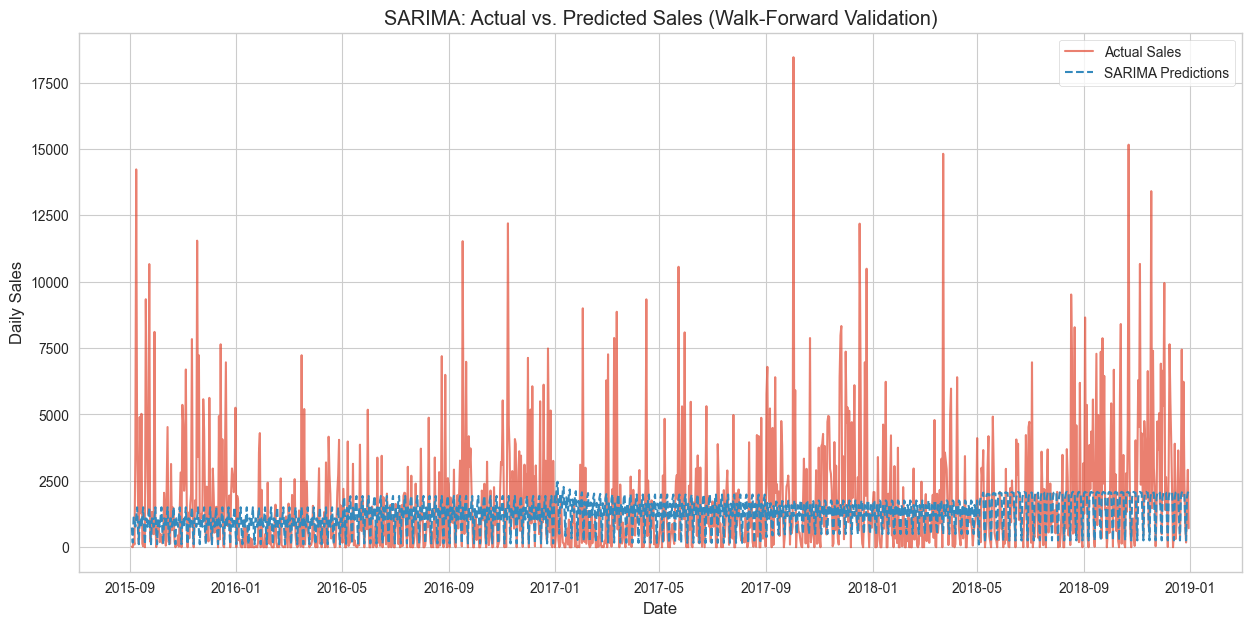

In [10]:
model_to_plot = 'SARIMA' # or 'Holt-Winters ES'
if model_to_plot in model_predictions_part2 and model_to_plot in all_actuals_part2:
    plt.figure(figsize=(15, 7))
    actuals = all_actuals_part2[model_to_plot]
    predictions = model_predictions_part2[model_to_plot]
    
    # Determine the time index for the plotted data (collected from test folds)
    num_predictions = len(actuals)
    # The actuals/predictions are from the test sets of the walk-forward validation.
    # We need to find the corresponding dates from `daily_sales.index`
    
    # This reconstruction assumes contiguous test splits from TimeSeriesSplit
    # Find the total number of observations used across all test splits
    total_test_obs = 0
    test_indices_list = []
    for _, test_idx_fold in tscv.split(daily_sales):
        total_test_obs += len(test_idx_fold)
        test_indices_list.extend(daily_sales.index[test_idx_fold])
        
    # Ensure the number of collected actuals matches the total test observations from splits
    if len(actuals) == total_test_obs:
        plot_index = pd.Index(test_indices_list).unique() # Get unique sorted dates
        # This index might still be longer if folds overlapped, but usually TimeSeriesSplit gives contiguous blocks
        # For simplicity, we assume the collected actuals align with the latter part of the series
        # A more robust way is to store indices along with predictions in the loop.
        plot_index_final = daily_sales.index[-len(actuals):] 

        plt.plot(plot_index_final, actuals, label='Actual Sales', alpha=0.7)
        plt.plot(plot_index_final, predictions, label=f'{model_to_plot} Predictions', linestyle='--')
        plt.title(f'{model_to_plot}: Actual vs. Predicted Sales (Walk-Forward Validation)')
        plt.xlabel('Date')
        plt.ylabel('Daily Sales')
        plt.legend()
        plt.show()
    else:
        print(f"Could not plot for {model_to_plot}: Mismatch in length of time index and predictions/actuals.")
        print(f"  Length of actuals: {len(actuals)}, Total test observations: {total_test_obs}")
else:
    print(f"Model '{model_to_plot}' not found in results for plotting.")